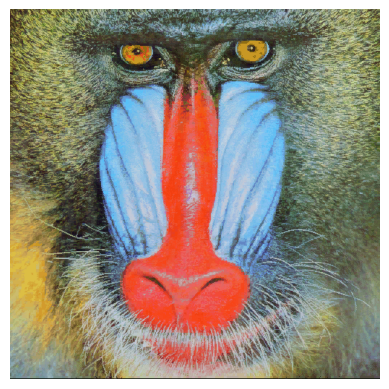

(512, 512, 3)


In [1]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

def plot_before_after(img_before, img_after):
    # plot side-by-side
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(1,2,1)
    plt.imshow(img_before)
    ax.set_title("Before")
    ax.axis("off")

    ax = fig.add_subplot(1,2,2)
    plt.imshow(img_after)
    ax.set_title("After")
    ax.axis("off")
    plt.show()

image_path = "./mandrill.png"

# download image if not exists
if not os.path.isfile(image_path):
    with open(image_path, 'wb') as f:
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        resp = requests.get("https://upload.wikimedia.org/wikipedia/commons/a/ab/Mandrill-k-means.png", headers=headers)
        assert resp.ok, resp.status_code
        f.write(resp.content)

# read in image
img = imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()
print(img.shape)

In [2]:
# convert image to 2d array by reshaping away the 3rd dimension
# Similar to the lecture,
# we treat each row as a feature, and each column as a sample
X = img.reshape(img.shape[0], -1)
print(X.shape)

(512, 1536)


In [3]:
# Perform SVD on the 2d array
U, s, VT = np.linalg.svd(np.cov(X, bias=True))
print("s shape:", s.shape)

s shape: (512,)


In [4]:
def explained_variance(s, k):
    ''' returns the explained variance when we keep the first k cols '''
    return sum(s[:k]) / sum(s)

minimum_retained_variance = 0.99
k = 0
var = 0
while var < minimum_retained_variance:
    k += 1
    var = explained_variance(s, k)

print("        k selected:", k)
print("explained variance:", var)

        k selected: 286
explained variance: 0.9901096501373663


In [5]:
Ur = U[:,:k]
Z  = Ur.T @ X
print("Ur shape:", Ur.shape)
print(" Z shape:", Z.shape)

# this is the space requirement
new_space = Ur.size + Z.size
print("Orig space requirement:", img.size)
print(" New space requirement:", new_space)
print("         % compression:", 100 * (img.size - new_space) / img.size)

Ur shape: (512, 286)
 Z shape: (286, 1536)
Orig space requirement: 786432
 New space requirement: 585728
         % compression: 25.520833333333332


In [6]:
def loss(X, X_approx):
    numer = np.square(X - X_approx).sum()
    denom = np.square(X).sum()
    return (numer / denom)

X_approx = Ur @ Z
print("original arr shape:", X.shape)
print("  approx arr shape:", X_approx.shape)
print("              loss:", loss(X, X_approx))

original arr shape: (512, 1536)
  approx arr shape: (512, 1536)
              loss: 0.0019268852066317917


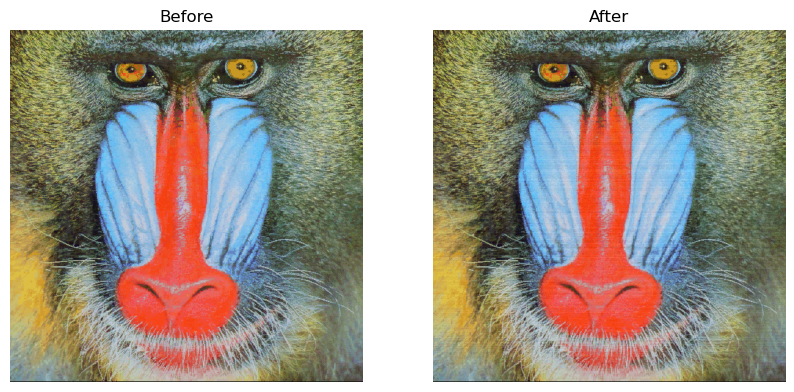

In [7]:
# reset the original image dimensions
img_approx = X_approx.reshape(*img.shape)
# clip values in case approximation exceeds bounds
img_approx = np.clip(img_approx, 0, 1)

plot_before_after(img, img_approx)

### Can we do SVD directly on the data matrix?

Yes we can!

In [8]:
# Perform SVD directly on X
U, s, VT = np.linalg.svd(X)
# Why X instead of cov matrix?
# Consider the cost of performing SVD
print("X shape:", X.shape)
print("s shape:", s.shape)

X shape: (512, 1536)
s shape: (512,)


In [9]:
def explained_variance2(s, k):
    ''' returns the explained variance when we keep the first k cols '''
    return sum(s[:k]**2) / sum(s**2)

minimum_retained_variance = 0.99
k = 0
var = 0
while var < minimum_retained_variance:
    k += 1
    var = explained_variance2(s, k)

print("        k selected:", k)
print("explained variance:", var)

        k selected: 99
explained variance: 0.9900800546825936


In [10]:
Ur = U[:, :k]
Z = Ur.T @ X
X_approx = Ur @ Z
print("Ur shape:", Ur.shape)
print(" Z shape:", Z.shape)

# this is the space requirement
new_space = Ur.size + Z.size
print("Orig space requirement:", img.size)
print(" New space requirement:", new_space)
print("         % compression:", 100 * (img.size - new_space) / img.size)

print("original arr shape:", X.shape)
print("  approx arr shape:", X_approx.shape)
print("              loss:", loss(X, X_approx))

#######################################
# Alternative ways to obtain X_approx #
#######################################
'''
vectors = VT[:k, :]
Z = X @ vectors.T
X_approx = Z @ vectors
'''
'''
Ur = U[:,:k]
sr = s[:k]
VTr = VT[:k,:]
X_approx = Ur @ np.diag(sr) @ VTr
'''


Ur shape: (512, 99)
 Z shape: (99, 1536)
Orig space requirement: 786432
 New space requirement: 202752
         % compression: 74.21875
original arr shape: (512, 1536)
  approx arr shape: (512, 1536)
              loss: 0.009919941


'\nUr = U[:,:k]\nsr = s[:k]\nVTr = VT[:k,:]\nX_approx = Ur @ np.diag(sr) @ VTr\n'

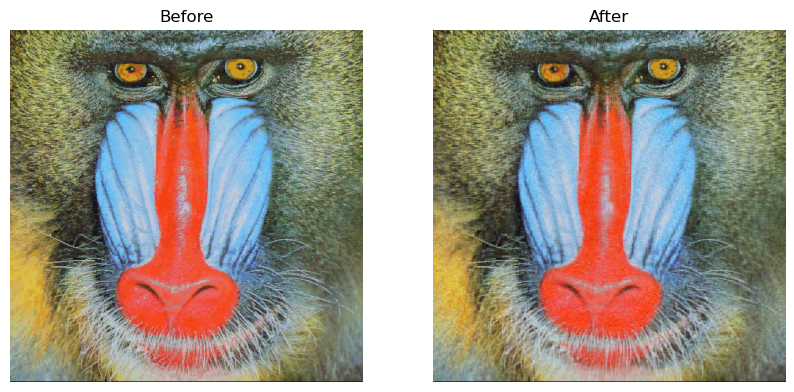

In [11]:
# reset the original image dimensions
img_approx = X_approx.reshape(*img.shape)
# clip values in case approximation exceeds bounds
img_approx = np.clip(img_approx, 0, 1)

plot_before_after(img, img_approx)